In [101]:
from functools import partial

import numpy as np
import PIL
import matplotlib.pyplot as plt
import trimesh
from trimesh import Scene

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [9]:


test = np.array([1, 1, 1, 2])
drws = np.random.rand(4, 1000) < 0.5

In [11]:
res = np.broadcast_to(np.atleast_2d(test), drws.T.shape) * drws.T

In [17]:
np.any(res == 2, axis=1).mean()

0.513

In [49]:


test = np.array([1, 1, 1, 2, 2, 2] * 3)
drws = np.random.rand(test.shape[0], 50_000) < 0.1
res = np.broadcast_to(np.atleast_2d(test), drws.T.shape) * drws.T

In reality its more of 'can I pick up there is a difference between these two?

In [50]:
res

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 0, 0]])

In [51]:
((res.sum(axis=1) % 3 == 0) * (res.sum(axis=1) > 0)).mean()

0.22424

In [52]:
(res[:,-1] > 0).mean()

0.09844

In [53]:
test = np.array([1, 1, 1, 1, 1, 2] * 2)
drws = np.random.rand(test.shape[0], 50_000) < 0.1
res = np.broadcast_to(np.atleast_2d(test), drws.T.shape) * drws.T

In [93]:
test = np.array([1, 1, 1, 2, 2, 2] * 4)
drws = np.random.rand(test.shape[0], 100_000) < 0.1
res1 = np.broadcast_to(np.atleast_2d(test), drws.T.shape) * drws.T
test2 = np.array([1, 1, 1, 1, 2, 2] * 4)
drws2 = np.random.rand(test2.shape[0], 100_000) < 0.1
res2 = np.broadcast_to(np.atleast_2d(test2), drws2.T.shape) * drws2.T

In [94]:
(res1.mean(axis=1) > res2.mean(axis=1)).mean()

0.48394

In [91]:
test = np.array([1, 1, 1, 1, 1, 2] * 4)
drws = np.random.rand(test.shape[0], 100_000) < 0.1
res1 = np.broadcast_to(np.atleast_2d(test), drws.T.shape) * drws.T
test2 = np.array([1, 1, 1, 1, 1, 1] * 4)
drws2 = np.random.rand(test2.shape[0], 100_000) < 0.1
res2 = np.broadcast_to(np.atleast_2d(test2), drws2.T.shape) * drws2.T

In [92]:
(res1.mean(axis=1) > res2.mean(axis=1)).mean()

0.47251

In [96]:

mesh = trimesh.load("../models/bunny.ply")

# Normalize the mesh using trimesh functionality
mesh.apply_translation(-mesh.centroid)
scale_factor = 1.0 / mesh.extents.max()
mesh.apply_scale(scale_factor)


<trimesh.Trimesh(vertices.shape=(8146, 3), faces.shape=(16301, 3))>

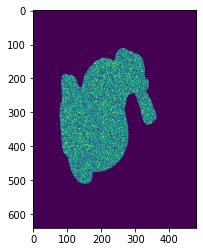

In [105]:

def get_transformed_scene(mesh, rotation_transform, translation_vector) -> Scene:
    transformed = mesh.copy()
    transformed.apply_transform(rotation_transform)
    # transformed.apply_translation(translation_vector)
    # tt = transformed.apply_obb()  # i guess it works..
    scene = Scene()
    scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)
    scene.apply_translation(translation_vector)
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    return scene


def raytrace_silhouette_precomputed(scene: Scene, vectors, pixels, perc=0.5):
    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    msk = np.random.rand(*scene.camera.resolution) < perc

    origin = np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), vectors.shape)

    # run the mesh- ray test
    points, index_ray, index_tri = scene.geometry["mesh"].ray.intersects_location(
        ray_origins=origin[msk.flat], ray_directions=vectors[msk.flat], multiple_hits=False
    )

    # find pixel locations of actual hits
    sub_pixels = pixels[msk.flat]
    pixel_ray = sub_pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a

# the problem is that the rays are computed before translation...
scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*[0, 0, 0]), [0, 0, 0])

# convert the camera to rays with one ray per pixel
origin, vectors, pixels = scene.camera_rays()
raytrace_silhouette = partial(raytrace_silhouette_precomputed, vectors=vectors, pixels=pixels)

sil = raytrace_silhouette(scene)

plt.imshow(sil == 2)

In [100]:
## jacaards index for comparing two incomplete masks:
def stochastic_jacaard_index(m1: np.ndarray, m2: np.ndarray):
    """Where 2 means positive, 1 means negative, and 0 means not measured/unknown, I / U should only consider knowns"""
    m1_pos = m1 == 2
    m2_pos = m2 == 2
    m1_neg = m1 == 1
    m2_neg = m2 == 1
    count_agree_pos = (m1_pos & m2_pos).sum()  # intersection
    count_pos = (m1_pos & m2_neg).sum() + (m1_neg & m2_pos).sum() + count_agree_pos
    if count_pos == 0:
        return 0
    return count_agree_pos / count_pos

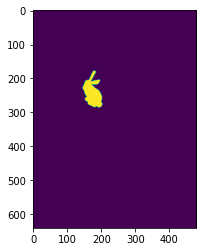

In [108]:


true_rotation = np.array([1, 0, 1])  # np.random.rand(3) * 2 * np.pi
true_translation = np.array([1, 1, 5])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*true_rotation), true_translation)
true_sil = raytrace_silhouette(scene, perc=1)

plt.imshow(true_sil == 2)

1.0


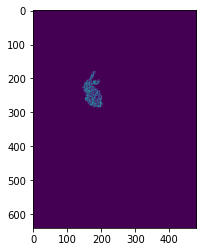

In [110]:
test_sil = raytrace_silhouette(scene, perc=.25)
print(stochastic_jacaard_index(test_sil, true_sil))
plt.imshow(test_sil == 2)

0.5154979674796748


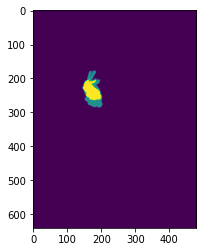

In [112]:

rotation = true_rotation + np.array([.2, .1, .2])
translation = true_translation + np.array([.3, 0.2, 1])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)
sil = raytrace_silhouette(scene, perc=1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow(sil + true_sil)

Now I need $\theta$ to define the configuration of the object and $L(\theta)$ to be loss from it


In [115]:
def get_scene_from_theta(theta: np.ndarray):
    # theta is rotation matrix, and translation matrix
    rotation = theta[:3]
    translation = theta[3:]
    rotation_matrix = trimesh.transformations.euler_matrix(*rotation)
    return get_transformed_scene(mesh, rotation_matrix, translation)

def get_loss_from_theta(theta: np.ndarray, perc=0.5):
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=perc)
    js = stochastic_jacaard_index(true_sil, sil)
    js = np.clip(js, 0.00001, 0.99999)
    log_odds = np.log(1 - js) - np.log(js)
    return log_odds

theta_0 = np.append(rotation, translation)
get_loss_from_theta(theta_0)


-0.08076135664445827

In [114]:

theta_opt = np.append(true_rotation, true_translation)
get_loss_from_theta(theta_opt)

-11.51291546492478

In [119]:
def ak_gain(k, a0=1e-2, A=1000, alpha=0.602):
    """Rule of thumb, A ~ <=10% max iterations expected
    a0 to be smallest of desired changes among theta early on"""
    a = a0 * (1 + A) ** alpha
    return a / (k + 1 + A) ** alpha


def ck_gain(k, c=1e-2, gamma=0.101):
    """Rule of thumb, c ~ std loss noise (e in y = L + e)"""
    return c / (k + 1) ** gamma


def bernouli_sample(p):
    while True:
        proba = np.random.rand(p)
        values = (proba < 0.5).astype(int) * 2 - 1
        yield values


def approx_gradient(loss, perturb, theta, c):
    # SPSA
    diff = loss(theta + c * perturb) - loss(theta - c * perturb)
    return (diff / (2 * c)) / perturb


def optim_spsa(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.05):
    theta = theta_0
    P = len(theta)
    k = 0
    for k, perturb in enumerate(bernouli_sample(P)):
        ak = ak_gen(k)
        ck = ck_gen(k)
        grad = approx_gradient(loss_fnc, perturb, theta, ck)
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta

optim = optim_spsa(np.array(theta_0), get_loss_from_theta, ak_gain, ck_gain)

In [120]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_theta(theta)}")

0: -0.10810099421592956
10: -0.3223784735453532
20: -0.35023347713791586
30: -0.5003037010138649
40: -0.5424991312838892
50: -0.49643688631389093
60: -0.8535966625352318
70: -0.9940073453922813
80: -0.9565444267469743
90: -1.2196263449059395


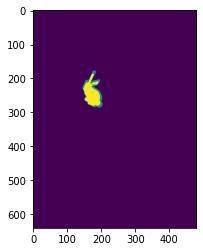

In [121]:
scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)
plt.imshow(sil + true_sil)

In [122]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_theta(theta)}")

0: -1.0971096587835745
10: -1.1458651735186551
20: -0.9253227979876596
30: -0.930419695328171
40: -0.965654454992491
50: -0.7961239048624955
60: -1.1069488280438762
70: -1.042668499051339
80: -1.1158089741300579
90: -1.0277108795688763


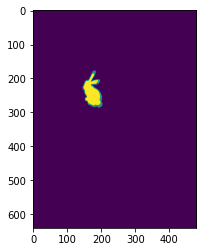

In [123]:
scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)
plt.imshow(sil + true_sil)

So it looks like optimization kind of works.